# Importing Datasets and libraries :

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    Flatten, Dense, Reshape, MaxPooling2D, Dropout, AveragePooling2D
)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications.vgg16 import preprocess_input

## Step 1: Load two common datasets

### Loading flowers dataset

In [4]:
# Function to load and preprocess images
def load_and_preprocess_data(folder_path, image_size=(224, 224)):
    image_data = []
    labels = []

    # Use tqdm for progress tracking in the first loop only
    for flower_type in tqdm(os.listdir(folder_path), desc="Loading and Preprocessing"):
        flower_folder = os.path.join(folder_path, flower_type)

        if os.path.isdir(flower_folder):
            for filename in os.listdir(flower_folder):
                image_path = os.path.join(flower_folder, filename)

                # Read and resize the image
                img = Image.open(image_path)
                img = img.resize(image_size)
                img_array = np.array(img)

                # Append the image data and label
                image_data.append(img_array)
                labels.append(flower_type)

    # Convert the lists to numpy arrays
    image_data = np.array(image_data)
    labels = np.array(labels)

    return image_data, labels

# Set the path to the flowers folder
folder_path = 'flowers'

# Load and preprocess the data
image_data, labels = load_and_preprocess_data(folder_path)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets with stratification
x_train_flowers, x_test_flowers, y_train_flowers, y_test_flowers = train_test_split(
    image_data, encoded_labels, test_size=0.2, random_state=42, stratify=labels
)

Loading and Preprocessing:   0%|          | 0/5 [00:00<?, ?it/s]

Loading and Preprocessing:   0%|          | 0/5 [00:20<?, ?it/s]


KeyboardInterrupt: 

### Loading cifar10 dataset

In [ ]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


### checking shapes :

In [ ]:
print(f'X train of cifar10 {x_train_cifar10.shape}')
print(f'y train of cifar10 {y_train_cifar10.shape}')
print('\n')
print(f'X Test of cifar10{x_test_cifar10.shape}')
print(f'y Test of cifar10{y_test_cifar10.shape}')
print('\n------------------------------------------------\n')
print(f'X Train of flowers {x_train_flowers.shape}')
print(f'y Train of flowers {y_train_flowers.shape}')
print('\n')
print(f'X Test of flowers {x_test_flowers.shape}')
print(f'y Test of flowers {y_test_flowers.shape}')

X train of cifar10 (50000, 32, 32, 3)
y train of cifar10 (50000, 1)


X Test of cifar10(10000, 32, 32, 3)
y Test of cifar10(10000, 1)

------------------------------------------------

X Train of flowers (3453, 224, 224, 3)
y Train of flowers (3453,)


X Test of flowers (864, 224, 224, 3)
y Test of flowers (864,)


In [ ]:
print(f'Classes/Categories of y train we want our model to predict in cifar10 {np.unique(y_train_cifar10)}')
print(f'Classes/Categories of y train we want our model to predict in MNIST {np.unique(y_train_flowers)}')

Classes/Categories of y train we want our model to predict in cifar10 [0 1 2 3 4 5 6 7 8 9]
Classes/Categories of y train we want our model to predict in MNIST [0 1 2 3 4]


## visualizing our labels

### For cifar10 Data set :

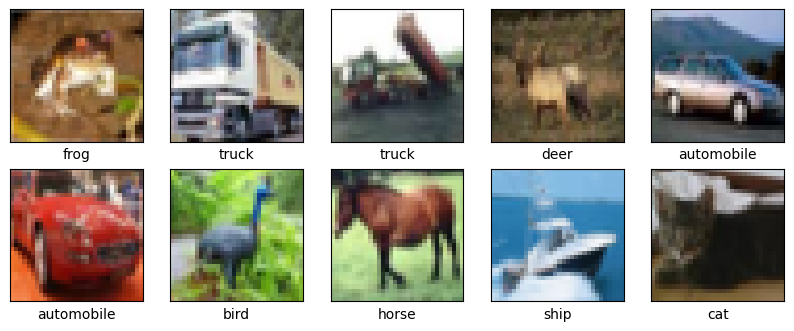

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_cifar10[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train_cifar10[i][0]])
plt.show()

### For flowers Data set :

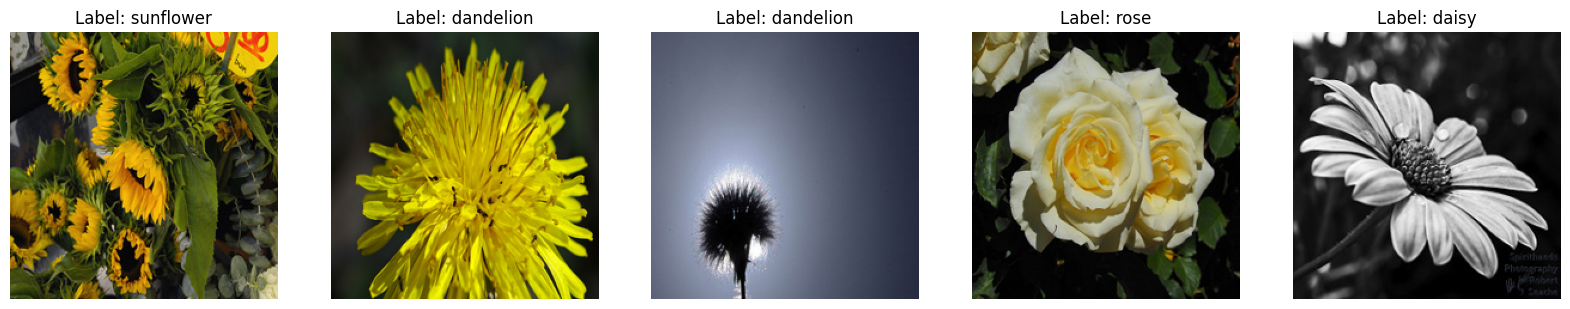

In [ ]:
# Visualize a few sample images with a larger figure size
num_samples_to_visualize = 5

plt.figure(figsize=(20, 8))  # Adjust the figsize to make it larger

for i in range(num_samples_to_visualize):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.imshow(x_train_flowers[i], cmap='gray')

    # Decode the label
    original_label = label_encoder.inverse_transform([y_train_flowers[i]])[0]

    plt.title(f"Label: {original_label}")
    plt.axis('off')

plt.show()

# Step 2: Pre-processing


In [ ]:
# Normalize the pixel values to be in the range [0, 1] for both datasets
x_train_cifar10, x_test_cifar10 = x_train_cifar10 / 255.0, x_test_cifar10 / 255.0
x_train_flowers, x_test_flowers = x_train_flowers / 255.0, x_test_flowers / 255.0

In [ ]:
# input shape and number of classes
input_shape_cifar10 = (32, 32, 3)
input_shape_flowers = (224, 224, 3)

num_classes_cifar10 = 10
num_classes_flowers = 5

## Step 3: building the Models

### VGG-16 from scratch

In [ ]:
def VGG16_from_scratch(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Adjust this for the number of classes in your dataset

    return model


In [ ]:
# Create ResNet-50 models for CIFAR-10 and flowers
vgg_model_scratch_cifar10 = VGG16_from_scratch(input_shape_cifar10, num_classes_cifar10)
vgg_model_scratch_flowers = VGG16_from_scratch(input_shape_flowers, num_classes_flowers)

#### Print VGG-16 architecture

In [ ]:
vgg_model_scratch_cifar10.summary()
vgg_model_scratch_flowers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                        

In [ ]:
# Compile the cifar10 model
vgg_model_scratch_cifar10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model_scratch_cifar10_history = vgg_model_scratch_cifar10.fit(x_train_cifar10, y_train_cifar10, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 51s 43ms/step - loss: 1.7015 - accuracy: 0.3597 - val_loss: 1.5327 - val_accuracy: 0.4484
Epoch 2/10
625/625 [==============================] - 26s 42ms/step - loss: 1.2596 - accuracy: 0.5587 - val_loss: 1.2278 - val_accuracy: 0.6071
Epoch 3/10
625/625 [==============================] - 27s 43ms/step - loss: 0.9670 - accuracy: 0.6718 - val_loss: 1.2568 - val_accuracy: 0.6021
Epoch 4/10
625/625 [==============================] - 27s 43ms/step - loss: 0.7971 - accuracy: 0.7323 - val_loss: 1.0885 - val_accuracy: 0.6495
Epoch 5/10
625/625 [==============================] - 27s 44ms/step - loss: 0.6620 - accuracy: 0.7819 - val_loss: 0.8184 - val_accuracy: 0.7422
Epoch 6/10
625/625 [==============================] - 27s 43ms/step - loss: 0.5539 - accuracy: 0.8189 - val_loss: 0.7074 - val_accuracy: 0.7830
Epoch 7/10
625/625 [==============================] - 27s 43ms/step - loss: 0.4675 - accuracy: 0.8495 - val_loss: 0.6278 - val_accuracy:

In [ ]:
# Compile the flowers model
vgg_model_scratch_flowers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model_scratch_flowers_history = vgg_model_scratch_flowers.fit(x_train_flowers, y_train_flowers, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
44/44 [==============================] - 93s 1s/step - loss: 23.8079 - accuracy: 0.2639 - val_loss: 2.3520 - val_accuracy: 0.2518
Epoch 2/30
44/44 [==============================] - 47s 1s/step - loss: 1.3293 - accuracy: 0.4193 - val_loss: 5.9524 - val_accuracy: 0.2475
Epoch 3/30
44/44 [==============================] - 47s 1s/step - loss: 1.2342 - accuracy: 0.4696 - val_loss: 3.9381 - val_accuracy: 0.2475
Epoch 4/30
44/44 [==============================] - 47s 1s/step - loss: 1.1683 - accuracy: 0.5163 - val_loss: 2.6335 - val_accuracy: 0.2475
Epoch 5/30
44/44 [==============================] - 47s 1s/step - loss: 1.0914 - accuracy: 0.5601 - val_loss: 2.9193 - val_accuracy: 0.2475
Epoch 6/30
44/44 [==============================] - 47s 1s/step - loss: 1.1107 - accuracy: 0.5503 - val_loss: 2.0909 - val_accuracy: 0.2576
Epoch 7/30
44/44 [==============================] - 48s 1s/step - loss: 1.0853 - accuracy: 0.5684 - val_loss: 3.6978 - val_accuracy: 0.2475
Epoch 8/30
44/44 [=

#### printing the learning curve of cifar10 Dataset to avoid overfitting :

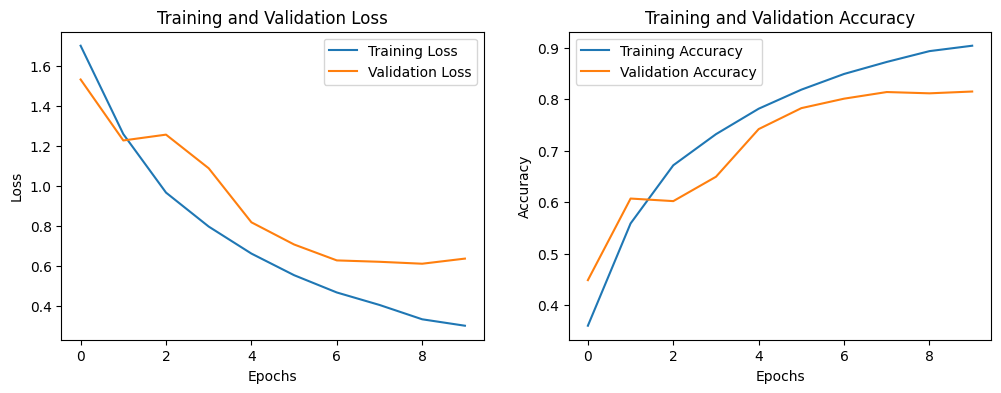

In [ ]:
# Access the training history
cifar10_loss = vgg_model_scratch_cifar10_history.history['loss']
cifar10_val_loss = vgg_model_scratch_cifar10_history.history['val_loss']
cifar10_accuracy = vgg_model_scratch_cifar10_history.history['accuracy']
cifar10_val_accuracy = vgg_model_scratch_cifar10_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cifar10_loss, label='Training Loss')
plt.plot(cifar10_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cifar10_accuracy, label='Training Accuracy')
plt.plot(cifar10_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### printing the learning curve of flowers Dataset to avoid overfitting :

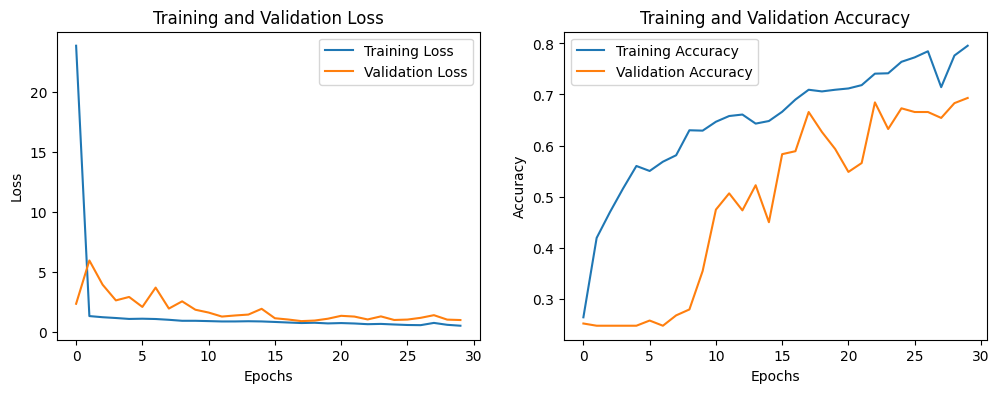

In [ ]:
# Access the training history
flowers_loss = vgg_model_scratch_flowers_history.history['loss']
flowers_val_loss = vgg_model_scratch_flowers_history.history['val_loss']
flowers_accuracy = vgg_model_scratch_flowers_history.history['accuracy']
flowers_val_accuracy = vgg_model_scratch_flowers_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(flowers_loss, label='Training Loss')
plt.plot(flowers_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(flowers_accuracy, label='Training Accuracy')
plt.plot(flowers_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Print confusion matrix relative to testing sampleS

In [ ]:
# Make predictions on the test set
y_pred_cifar10 = vgg_model_scratch_cifar10.predict(x_test_cifar10)
y_pred_flowers = vgg_model_scratch_flowers.predict(x_test_flowers)

27/27 [==============================] - 9s 144ms/step


In [ ]:
# Convert to class labels
y_pred_cifar10 = np.argmax(y_pred_cifar10, axis=1)
y_pred_flowers = np.argmax(y_pred_flowers, axis=1)

#### Confusion Matrix for cifar10

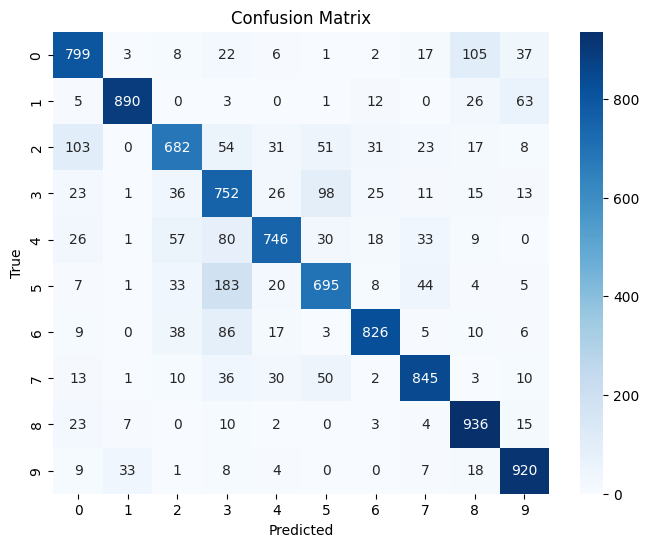

In [ ]:
# Calculate the confusion matrix
cm_cifar10 = confusion_matrix(y_test_cifar10, y_pred_cifar10)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cifar10, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_cifar10, y_pred_cifar10, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.8145811943385508
Recall: 0.8090999999999999
F1 Score: 0.8095565193939068


#### Confusion Matrix for flowers

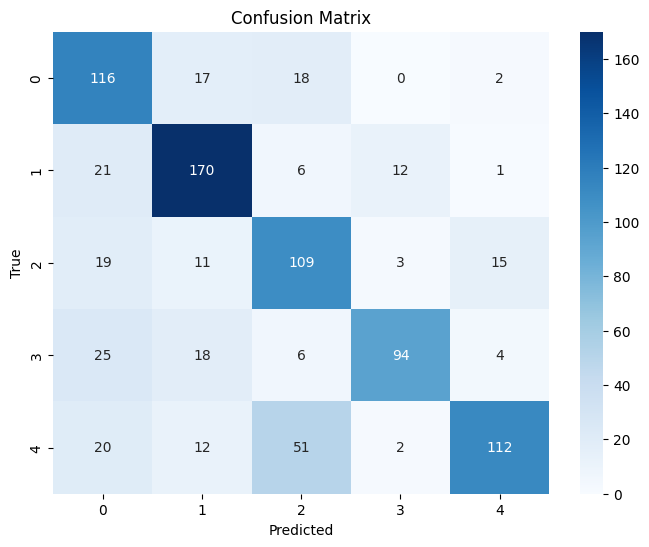

In [ ]:
# Calculate the confusion matrix
cm_flowers = confusion_matrix(y_test_flowers, y_pred_flowers)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_flowers, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_flowers, y_pred_flowers, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.7158160831687933
Recall: 0.6939889922365101
F1 Score: 0.6930568689984822


### VGG was supposed to work better on flowers dataset and didn't work on the cifar dataset (0.01 accuracy) because VGG was originally designed for images with input shape (224, 224) like flowers dataset not for small inputs like cifar (32,32)


### thats why we mpdified the model as we included a batch normalization after each conv layer and modified the strides from (2,2) to its default (1,1) that made the cifar dataset work but these modifications affected the accuracy of the flowers dataset thats why the cifar dataset accuracy surpassed the flowers

### VGG-16 pretrained model

In [ ]:
def VGG16_pretrained(input_shape, num_classes):
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers to prevent training during fine-tuning
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for the specific number of classes
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Adjust this for the number of classes in your dataset

    return model

In [ ]:
# Create ResNet-50 models for CIFAR-10 and flowers
vgg_model_pretrained_cifar10 = VGG16_pretrained(input_shape_cifar10, num_classes_cifar10)
vgg_model_pretrained_flowers = VGG16_pretrained(input_shape_flowers, num_classes_flowers)

58889256/58889256 [==============================] - 0s 0us/step


#### Print VGG-16 architecture

In [ ]:
vgg_model_pretrained_cifar10.summary()
vgg_model_pretrained_flowers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [ ]:
# Compile the cifar10 model
vgg_model_pretrained_cifar10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model_pretrained_cifar10_history = vgg_model_pretrained_cifar10.fit(x_train_cifar10, y_train_cifar10, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 13s 18ms/step - loss: 1.4776 - accuracy: 0.4802 - val_loss: 1.3128 - val_accuracy: 0.5360
Epoch 2/10
625/625 [==============================] - 10s 17ms/step - loss: 1.3032 - accuracy: 0.5444 - val_loss: 1.2185 - val_accuracy: 0.5719
Epoch 3/10
625/625 [==============================] - 10s 17ms/step - loss: 1.2553 - accuracy: 0.5574 - val_loss: 1.1992 - val_accuracy: 0.5833
Epoch 4/10
625/625 [==============================] - 10s 17ms/step - loss: 1.2162 - accuracy: 0.5741 - val_loss: 1.1922 - val_accuracy: 0.5869
Epoch 5/10
625/625 [==============================] - 10s 17ms/step - loss: 1.1881 - accuracy: 0.5828 - val_loss: 1.1593 - val_accuracy: 0.5967
Epoch 6/10
625/625 [==============================] - 10s 17ms/step - loss: 1.1638 - accuracy: 0.5913 - val_loss: 1.1656 - val_accuracy: 0.5995
Epoch 7/10
625/625 [==============================] - 10s 17ms/step - loss: 1.1435 - accuracy: 0.5966 - val_loss: 1.1412 - val_accuracy:

In [ ]:
# Compile the flowers model
vgg_model_pretrained_flowers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model_pretrained_flowers_history = vgg_model_pretrained_flowers.fit(x_train_flowers, y_train_flowers, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
44/44 [==============================] - 19s 396ms/step - loss: 5.2504 - accuracy: 0.4986 - val_loss: 0.9440 - val_accuracy: 0.6295
Epoch 2/10
44/44 [==============================] - 16s 369ms/step - loss: 0.7281 - accuracy: 0.7343 - val_loss: 0.5758 - val_accuracy: 0.8003
Epoch 3/10
44/44 [==============================] - 16s 364ms/step - loss: 0.5144 - accuracy: 0.8056 - val_loss: 0.6510 - val_accuracy: 0.7728
Epoch 4/10
44/44 [==============================] - 16s 360ms/step - loss: 0.5133 - accuracy: 0.8110 - val_loss: 0.5751 - val_accuracy: 0.8046
Epoch 5/10
44/44 [==============================] - 16s 361ms/step - loss: 0.4667 - accuracy: 0.8262 - val_loss: 0.5919 - val_accuracy: 0.7786
Epoch 6/10
44/44 [==============================] - 16s 362ms/step - loss: 0.4219 - accuracy: 0.8454 - val_loss: 0.6100 - val_accuracy: 0.7815
Epoch 7/10
44/44 [==============================] - 16s 363ms/step - loss: 0.3828 - accuracy: 0.8592 - val_loss: 0.5325 - val_accuracy: 0.8104

#### printing the learning curve of cifar10 Dataset to avoid overfitting :

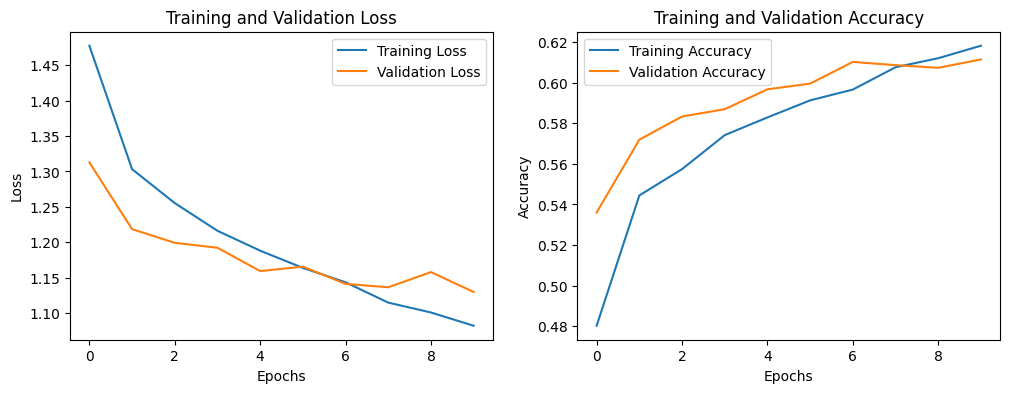

In [ ]:
# Access the training history
cifar10_loss = vgg_model_pretrained_cifar10_history.history['loss']
cifar10_val_loss = vgg_model_pretrained_cifar10_history.history['val_loss']
cifar10_accuracy = vgg_model_pretrained_cifar10_history.history['accuracy']
cifar10_val_accuracy = vgg_model_pretrained_cifar10_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cifar10_loss, label='Training Loss')
plt.plot(cifar10_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cifar10_accuracy, label='Training Accuracy')
plt.plot(cifar10_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### printing the learning curve of flowers Dataset to avoid overfitting :

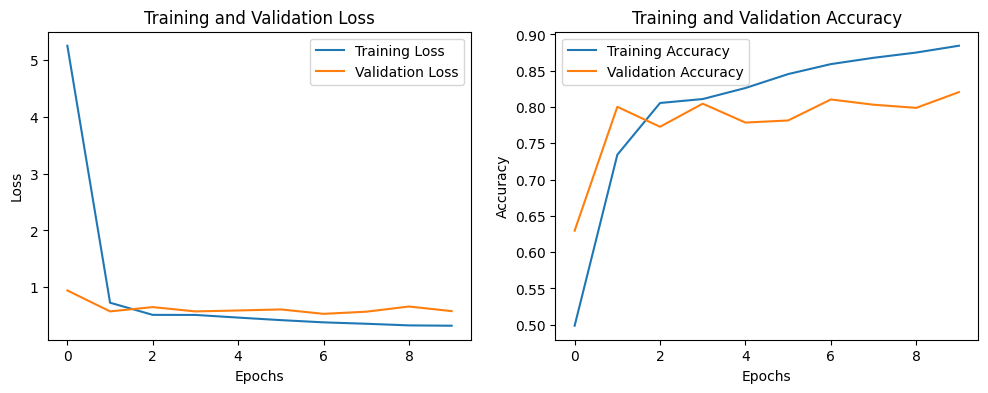

In [ ]:
# Access the training history
flowers_loss = vgg_model_pretrained_flowers_history.history['loss']
flowers_val_loss = vgg_model_pretrained_flowers_history.history['val_loss']
flowers_accuracy = vgg_model_pretrained_flowers_history.history['accuracy']
flowers_val_accuracy = vgg_model_pretrained_flowers_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(flowers_loss, label='Training Loss')
plt.plot(flowers_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(flowers_accuracy, label='Training Accuracy')
plt.plot(flowers_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Print confusion matrix relative to testing samples

In [ ]:
# Make predictions on the test set
y_pred_cifar10 = vgg_model_pretrained_cifar10.predict(x_test_cifar10)
y_pred_flowers = vgg_model_pretrained_flowers.predict(x_test_flowers)

27/27 [==============================] - 4s 138ms/step


In [ ]:
# Convert to class labels
y_pred_cifar10 = np.argmax(y_pred_cifar10, axis=1)
y_pred_flowers = np.argmax(y_pred_flowers, axis=1)

#### Confusion Matrix for cifar10

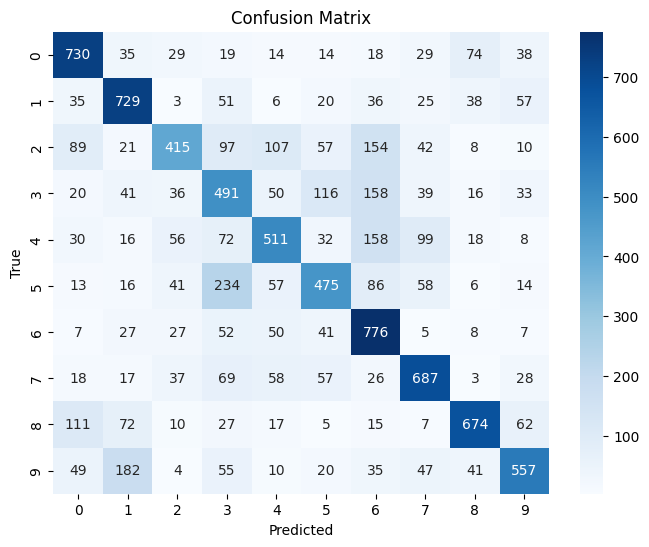

In [ ]:
# Calculate the confusion matrix
cm_cifar10 = confusion_matrix(y_test_cifar10, y_pred_cifar10)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cifar10, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_cifar10, y_pred_cifar10, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.6130302601434223
Recall: 0.6045
F1 Score: 0.6018782481371602


#### Confusion Matrix for flowers

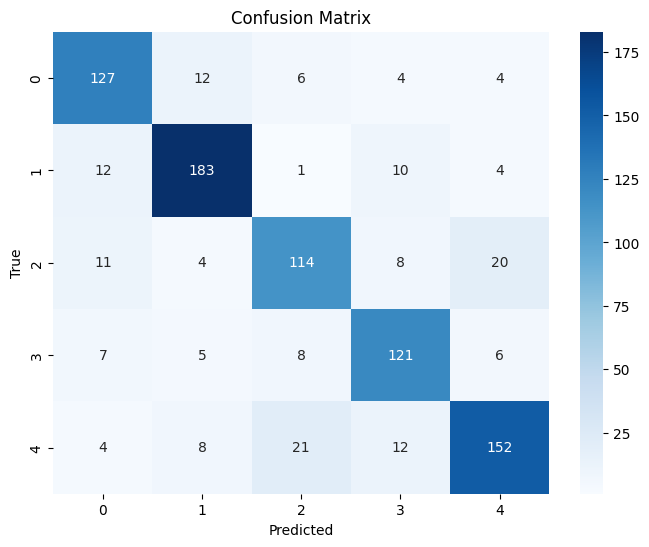

In [ ]:
# Calculate the confusion matrix
cm_flowers = confusion_matrix(y_test_flowers, y_pred_flowers)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_flowers, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_flowers, y_pred_flowers, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.80197537706236
Recall: 0.8044622872697635
F1 Score: 0.8027889940393335


### when using pretrained VGG we can see that it has way better accuracy than the cifar dataset thanks to the imagenet dataset that is it's trained on and with better optimizations we can make the accuracy go higher

### ResNet50 from scratch

In [ ]:
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    return x

def ResNet50_from_scratch(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = inputs

    if input_shape[-1] == 1:  # Resize MNIST images to (32, 32, 3)
        x = tf.image.grayscale_to_rgb(x)
        x = tf.image.resize(x, (32, 32))

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, filters=64, strides=1)
    x = residual_block(x, filters=64, strides=1)
    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128, strides=1)
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256, strides=1)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
# Create ResNet-50 models for CIFAR-10 and flowers
resnet_model_scratch_cifar10 = ResNet50_from_scratch(input_shape_cifar10, num_classes_cifar10)
resnet_model_scratch_flowers = ResNet50_from_scratch(input_shape_flowers, num_classes_flowers)

#### Print ResNet-50 architecture

In [ ]:
resnet_model_scratch_cifar10.summary()
resnet_model_scratch_flowers.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 16, 16, 64)           9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_24 (Ba  (None, 16, 16, 64)           256       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization_24[0

In [ ]:
# Compile the cifar10 model
resnet_model_scratch_cifar10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model_scratch_cifar10_history = resnet_model_scratch_cifar10.fit(x_train_cifar10, y_train_cifar10, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 22s 18ms/step - loss: 1.8520 - accuracy: 0.4039 - val_loss: 1.7285 - val_accuracy: 0.4074
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 1.2587 - accuracy: 0.5646 - val_loss: 1.3718 - val_accuracy: 0.5222
Epoch 3/10
625/625 [==============================] - 10s 17ms/step - loss: 0.9941 - accuracy: 0.6517 - val_loss: 1.3098 - val_accuracy: 0.5607
Epoch 4/10
625/625 [==============================] - 10s 17ms/step - loss: 0.8196 - accuracy: 0.7168 - val_loss: 1.7417 - val_accuracy: 0.4825
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 0.6731 - accuracy: 0.7673 - val_loss: 0.9398 - val_accuracy: 0.7009
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 0.5440 - accuracy: 0.8103 - val_loss: 1.0368 - val_accuracy: 0.6658
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 0.4215 - accuracy: 0.8518 - val_loss: 0.9431 - val_accuracy:

In [ ]:
# Compile the flowers model
resnet_model_scratch_flowers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model_scratch_flowers_history = resnet_model_scratch_flowers.fit(x_train_flowers, y_train_flowers, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
44/44 [==============================] - 47s 725ms/step - loss: 23.4291 - accuracy: 0.2983 - val_loss: 268.4774 - val_accuracy: 0.2504
Epoch 2/10
44/44 [==============================] - 26s 600ms/step - loss: 4.7794 - accuracy: 0.3812 - val_loss: 3.3685 - val_accuracy: 0.2576
Epoch 3/10
44/44 [==============================] - 26s 599ms/step - loss: 2.2598 - accuracy: 0.4761 - val_loss: 3.6572 - val_accuracy: 0.2576
Epoch 4/10
44/44 [==============================] - 27s 603ms/step - loss: 2.4112 - accuracy: 0.4801 - val_loss: 1.5818 - val_accuracy: 0.2808
Epoch 5/10
44/44 [==============================] - 26s 602ms/step - loss: 1.6744 - accuracy: 0.5768 - val_loss: 2.1434 - val_accuracy: 0.2967
Epoch 6/10
44/44 [==============================] - 26s 600ms/step - loss: 1.4649 - accuracy: 0.5825 - val_loss: 2.1593 - val_accuracy: 0.3980
Epoch 7/10
44/44 [==============================] - 26s 600ms/step - loss: 1.1752 - accuracy: 0.6528 - val_loss: 3.1121 - val_accuracy: 0.2

#### printing the learning curve of cifar10 Dataset to avoid overfitting :

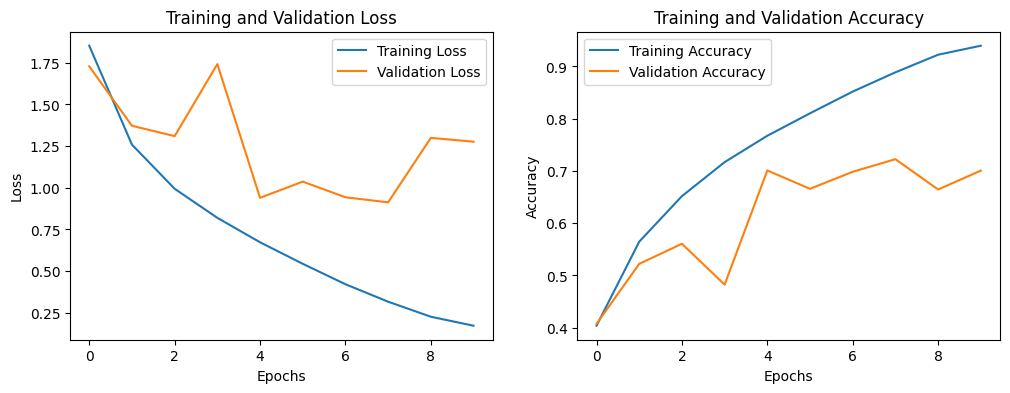

In [ ]:
# Access the training history
cifar10_loss = resnet_model_scratch_cifar10_history.history['loss']
cifar10_val_loss = resnet_model_scratch_cifar10_history.history['val_loss']
cifar10_accuracy = resnet_model_scratch_cifar10_history.history['accuracy']
cifar10_val_accuracy = resnet_model_scratch_cifar10_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cifar10_loss, label='Training Loss')
plt.plot(cifar10_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cifar10_accuracy, label='Training Accuracy')
plt.plot(cifar10_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### printing the learning curve of flowers Dataset to avoid overfitting :

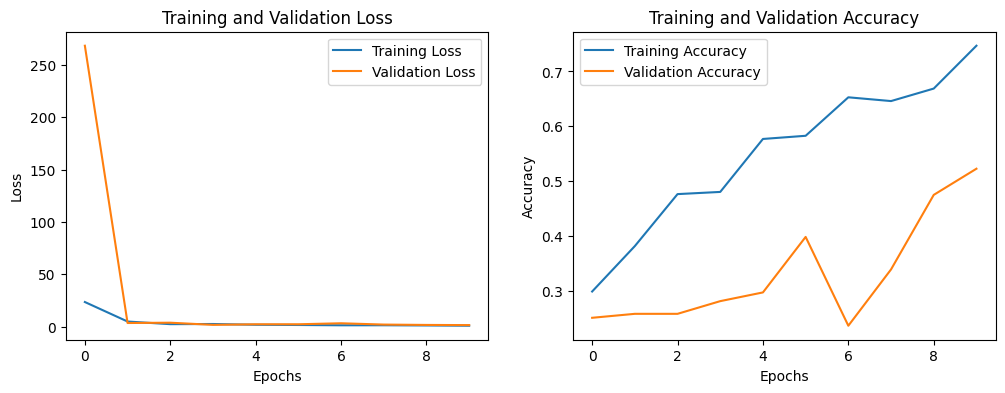

In [ ]:
# Access the training history
flowers_loss = resnet_model_scratch_flowers_history.history['loss']
flowers_val_loss = resnet_model_scratch_flowers_history.history['val_loss']
flowers_accuracy = resnet_model_scratch_flowers_history.history['accuracy']
flowers_val_accuracy = resnet_model_scratch_flowers_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(flowers_loss, label='Training Loss')
plt.plot(flowers_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(flowers_accuracy, label='Training Accuracy')
plt.plot(flowers_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Print confusion matrix relative to testing sampleS

In [ ]:
# Make predictions on the test set
y_pred_cifar10 = resnet_model_scratch_cifar10.predict(x_test_cifar10)
y_pred_flowers = resnet_model_scratch_flowers.predict(x_test_flowers)

27/27 [==============================] - 4s 78ms/step


In [ ]:
# Convert to class labels
y_pred_cifar10 = np.argmax(y_pred_cifar10, axis=1)
y_pred_flowers = np.argmax(y_pred_flowers, axis=1)

#### Confusion Matrix for cifar10

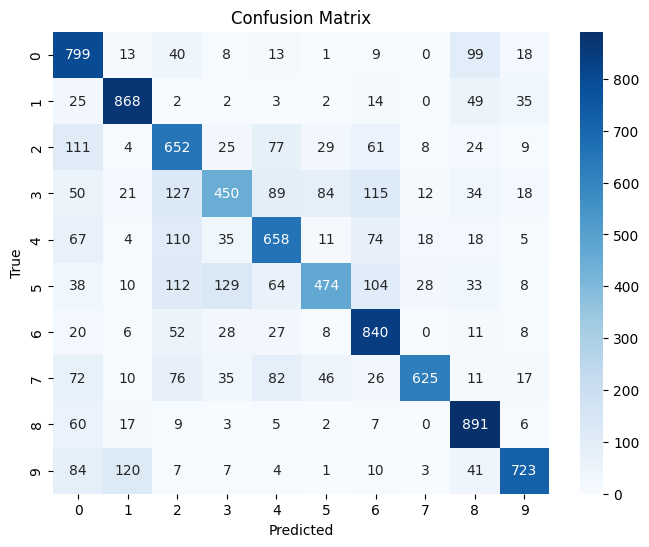

In [ ]:
# Calculate the confusion matrix
cm_cifar10 = confusion_matrix(y_test_cifar10, y_pred_cifar10)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cifar10, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_cifar10, y_pred_cifar10, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.71048634995901
Recall: 0.698
F1 Score: 0.6936085256890797


#### Confusion Matrix for flowers

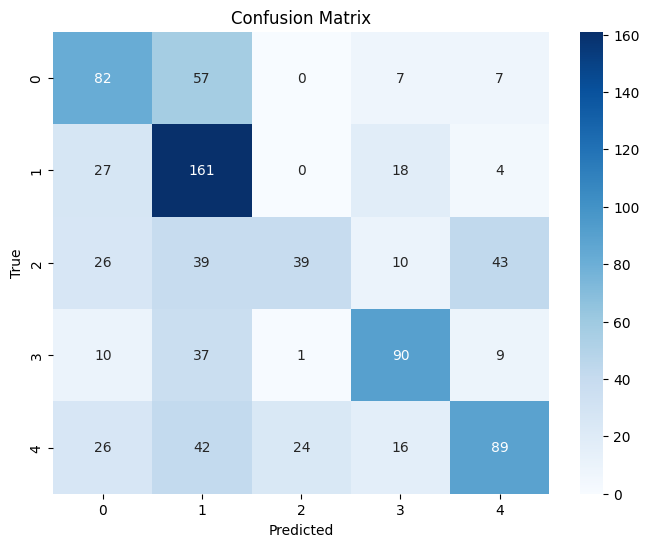

In [ ]:
# Calculate the confusion matrix
cm_flowers = confusion_matrix(y_test_flowers, y_pred_flowers)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_flowers, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_flowers, y_pred_flowers, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.5583796037078512
Recall: 0.5230087140204891
F1 Score: 0.516777251803096


### CIFAR-10 consists of 60,000 32x32 color images in 10 different classes, whereas the Flowers dataset has 3,453 images with larger dimensions (224x224) and more classes. CIFAR-10 is specifically designed for benchmarking models on image classification tasks, and its images are relatively small and simple compared to the Flowers dataset. The complexity of the Flowers dataset might make it more challenging for the model to learn discriminative features.

### While the ResNet architecture is powerful and has proven effective on a variety of tasks, the specific configuration provided might not be optimal for the Flowers dataset. The depth and complexity of the model may not be well-suited for smaller datasets or datasets with different characteristics. Adjusting the architecture or hyperparameters might be necessary for better performance on the Flowers dataset.

### The CIFAR-10 dataset is larger (50,000 training images) compared to the Flowers dataset (3,453 images). Deep learning models, especially complex ones like ResNet, often require a substantial amount of diverse training data to generalize well to new data. If the Flowers dataset is too small, the model may struggle to learn meaningful representations.

### Data augmentation is crucial for improving model generalization, especially when the dataset is relatively small. Ensure that you are using appropriate data augmentation techniques during training to artificially increase the size and diversity of the training set.

### ResNet50 pretrained model

In [ ]:
def ResNet50_pretrained(input_shape, num_classes):
    # Load pre-trained ResNet50 model with ImageNet weights (not including the top classification layer)
    pretrained_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers to retain their weights
    for layer in pretrained_resnet.layers:
        layer.trainable = False

    # Add your own classification layers on top of the pre-trained ResNet50 base
    x = Flatten()(pretrained_resnet.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create a new model with ResNet50 base and custom classification layers
    custom_resnet_model = Model(inputs=pretrained_resnet.input, outputs=predictions)

    # Compile the model
    custom_resnet_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return custom_resnet_model

In [ ]:
# Get pretrained ResNet models for flowers and CIFAR-10
resnet_model_pretrained_cifar10 = ResNet50_pretrained(input_shape_cifar10, num_classes_cifar10)
resnet_model_pretrained_flowers = ResNet50_pretrained(input_shape_flowers, num_classes_flowers)

94765736/94765736 [==============================] - 0s 0us/step


#### Print ResNet-50 architecture

In [ ]:
resnet_model_pretrained_cifar10.summary()
resnet_model_pretrained_flowers.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Compile the cifar10 model
resnet_model_pretrained_cifar10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model_pretrained_cifar10_history = resnet_model_pretrained_cifar10.fit(x_train_cifar10, y_train_cifar10, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
625/625 [==============================] - 14s 16ms/step - loss: 2.0885 - accuracy: 0.2464 - val_loss: 1.8987 - val_accuracy: 0.3149
Epoch 2/30
625/625 [==============================] - 8s 13ms/step - loss: 1.8964 - accuracy: 0.3091 - val_loss: 1.8861 - val_accuracy: 0.3107
Epoch 3/30
625/625 [==============================] - 9s 14ms/step - loss: 1.8564 - accuracy: 0.3264 - val_loss: 1.7990 - val_accuracy: 0.3450
Epoch 4/30
625/625 [==============================] - 8s 14ms/step - loss: 1.8163 - accuracy: 0.3431 - val_loss: 1.7792 - val_accuracy: 0.3543
Epoch 5/30
625/625 [==============================] - 8s 14ms/step - loss: 1.7818 - accuracy: 0.3566 - val_loss: 1.8171 - val_accuracy: 0.3349
Epoch 6/30
625/625 [==============================] - 8s 13ms/step - loss: 1.7700 - accuracy: 0.3647 - val_loss: 1.7695 - val_accuracy: 0.3519
Epoch 7/30
625/625 [==============================] - 8s 13ms/step - loss: 1.7581 - accuracy: 0.3626 - val_loss: 1.7842 - val_accuracy: 0.340

In [ ]:
# Compile the flowers model
resnet_model_pretrained_flowers.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model_pretrained_flowers_history = resnet_model_pretrained_flowers.fit(x_train_flowers, y_train_flowers, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
44/44 [==============================] - 22s 360ms/step - loss: 14.5220 - accuracy: 0.2752 - val_loss: 2.1621 - val_accuracy: 0.2489
Epoch 2/20
44/44 [==============================] - 12s 263ms/step - loss: 1.7064 - accuracy: 0.3965 - val_loss: 2.3521 - val_accuracy: 0.3531
Epoch 3/20
44/44 [==============================] - 12s 270ms/step - loss: 1.6985 - accuracy: 0.4095 - val_loss: 2.1589 - val_accuracy: 0.3271
Epoch 4/20
44/44 [==============================] - 12s 263ms/step - loss: 1.5906 - accuracy: 0.4468 - val_loss: 1.5218 - val_accuracy: 0.4153
Epoch 5/20
44/44 [==============================] - 11s 257ms/step - loss: 1.1597 - accuracy: 0.5442 - val_loss: 1.4334 - val_accuracy: 0.4472
Epoch 6/20
44/44 [==============================] - 11s 255ms/step - loss: 1.3139 - accuracy: 0.5080 - val_loss: 1.8056 - val_accuracy: 0.3719
Epoch 7/20
44/44 [==============================] - 11s 254ms/step - loss: 1.0899 - accuracy: 0.5615 - val_loss: 1.4798 - val_accuracy: 0.447

#### printing the learning curve of cifar10 Dataset to avoid overfitting :

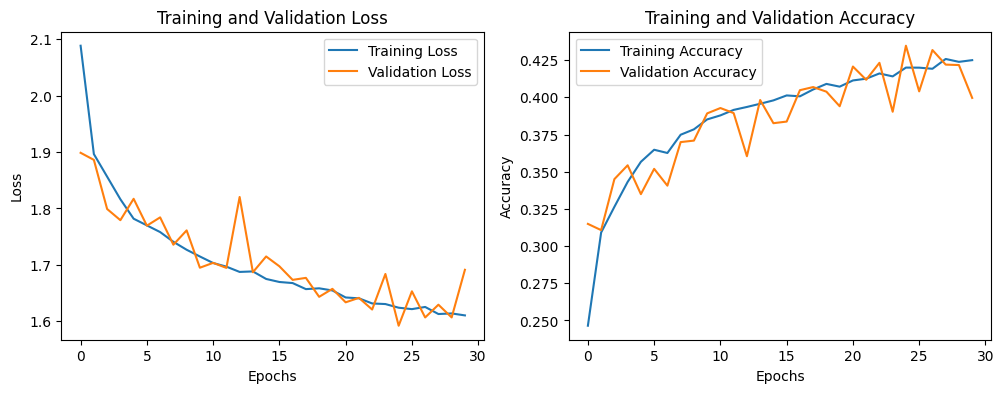

In [ ]:
# Access the training history
cifar10_loss = resnet_model_pretrained_cifar10_history.history['loss']
cifar10_val_loss = resnet_model_pretrained_cifar10_history.history['val_loss']
cifar10_accuracy = resnet_model_pretrained_cifar10_history.history['accuracy']
cifar10_val_accuracy = resnet_model_pretrained_cifar10_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cifar10_loss, label='Training Loss')
plt.plot(cifar10_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cifar10_accuracy, label='Training Accuracy')
plt.plot(cifar10_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### printing the learning curve of flowers Dataset to avoid overfitting :

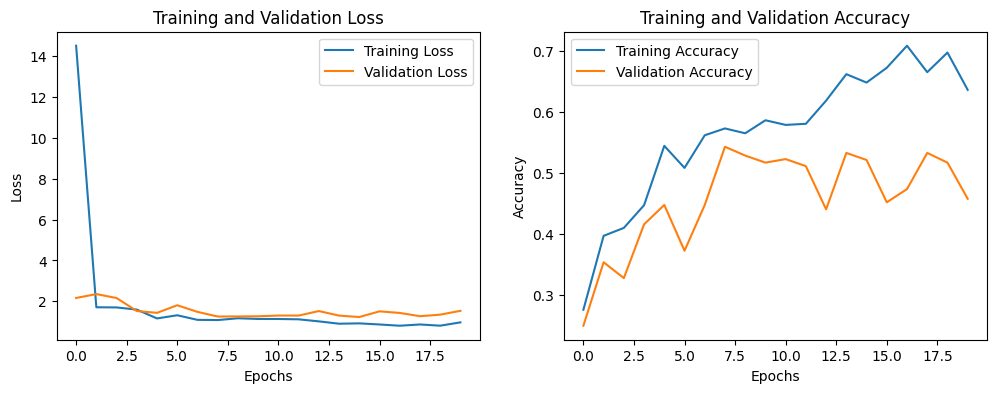

In [ ]:
# Access the training history
flowers_loss = resnet_model_pretrained_flowers_history.history['loss']
flowers_val_loss = resnet_model_pretrained_flowers_history.history['val_loss']
flowers_accuracy = resnet_model_pretrained_flowers_history.history['accuracy']
flowers_val_accuracy = resnet_model_pretrained_flowers_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(flowers_loss, label='Training Loss')
plt.plot(flowers_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(flowers_accuracy, label='Training Accuracy')
plt.plot(flowers_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Print confusion matrix relative to testing samples

In [ ]:
# Make predictions on the test set
y_pred_cifar10 = resnet_model_pretrained_cifar10.predict(x_test_cifar10)
y_pred_flowers = resnet_model_pretrained_flowers.predict(x_test_flowers)

27/27 [==============================] - 5s 95ms/step


In [ ]:
# Convert to class labels
y_pred_cifar10 = np.argmax(y_pred_cifar10, axis=1)
y_pred_flowers = np.argmax(y_pred_flowers, axis=1)

#### Confusion Matrix for cifar10

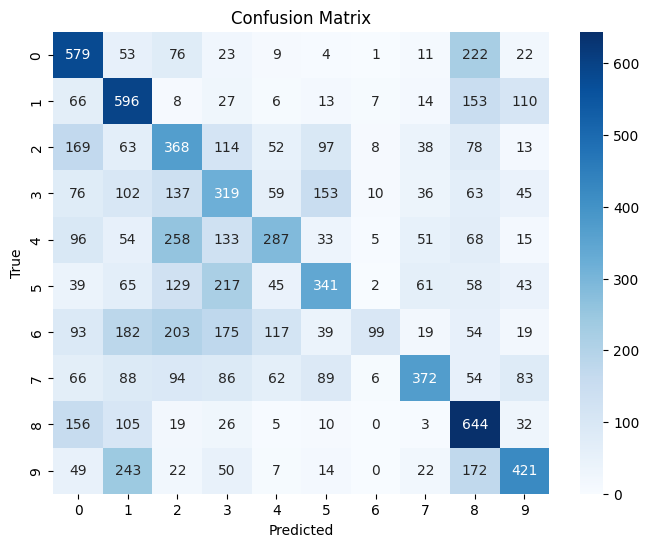

In [ ]:
# Calculate the confusion matrix
cm_cifar10 = confusion_matrix(y_test_cifar10, y_pred_cifar10)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cifar10, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_cifar10, y_pred_cifar10, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.44722722302942214
Recall: 0.40259999999999996
F1 Score: 0.389274120582058


#### Confusion Matrix for flowers

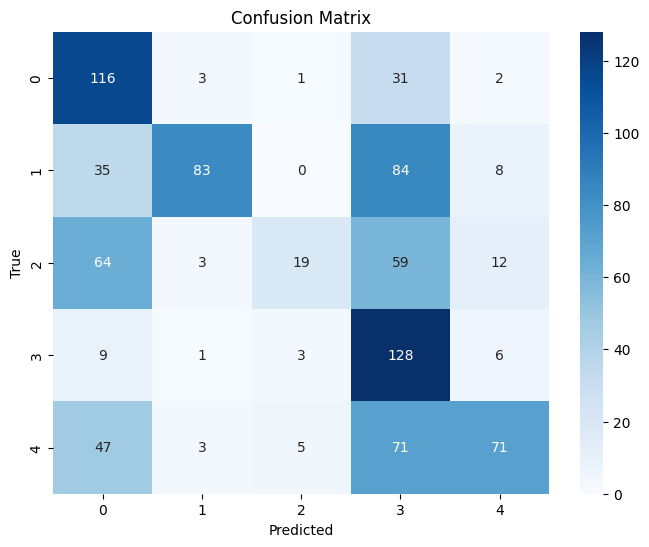

In [ ]:
# Calculate the confusion matrix
cm_flowers = confusion_matrix(y_test_flowers, y_pred_flowers)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_flowers, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_flowers, y_pred_flowers, average='macro')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.611884816667903
Recall: 0.5011163057698318
F1 Score: 0.454493484848426


### Freezing all the pre-trained layers may not be optimal for your specific datasets. Fine-tuning some of the later layers or modifying the architecture might be necessary to adapt the model to the new datasets.

### Learning Rate:

### The learning rate used during fine-tuning could affect the model's ability to adapt to the new datasets. Experiment with different learning rates to find an optimal value.